In [0]:
!pip install pyspark

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
(sc, spark)

(<SparkContext master=spark://10.139.64.10:7077 appName=Databricks Shell>,
 <pyspark.sql.session.SparkSession at 0x7f4806361270>)

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("MLlib lab") \
    .config("spark.sql.parquet.enableVectorizedReader", "false") \
    .getOrCreate()
    
# swith the latest spark version to older one so that it tolerates some data format issues
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

""" 
in order to avoid "Parquet column cannot be converted" error, we need to disable vectorized reader when we have decimal values in our columns. 
refer to https://learn.microsoft.com/en-us/answers/questions/853861/parquet-column-cannot-be-converted for further info
"""
# spark.conf.set("spark.sql.parquet.enableVectorizedReader", "false") 

sc = spark.sparkContext


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import Row

In [0]:
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType, TimestampNTZType, LongType, DoubleType,IntegerType
"""
We have encountered "Parquet column cannot be converted" error. As a workaround we decided to loop through directory and ensure there is no column type mismatch by checking file by file.
"""

directory = '/mnt/2024-team14/'

# List all parquet files
parquet_files = dbutils.fs.ls(directory)
#print(parquet_files)
#weather_file = parquet_files.pop()
#taxi_lookup = parquet_files.pop()
#json = parquet_files.pop()
#traffic = parquet_files.pop()

# Loop through directory and check where there is a column type mismatch between files
"""prev_types, curr_types = None, None
mismatches = {}
for file in parquet_files: 
  if file.path == "/mnt/2024-team14/weather_data.csv": 
    df1 = spark.read.csv(path) 
    continue
  # Read the Parquet file with schema inference
  df = spark.read.parquet(file.path)

  if not prev_types and not curr_types:
    curr_types = df.dtypes
    continue
  
  prev_types = curr_types
  curr_types = df.dtypes

  # check each column
  for i in range(len(df.columns)):
    if prev_types[i] != curr_types[i]:
      if not file.name in mismatches:
        mismatches[file.name] = [(prev_types[i][0], (prev_types[i][1], curr_types[i][1]))]
      else:
        mismatches[file.name].append((prev_types[i][0], (prev_types[i][1], curr_types[i][1])))"""

# print(mismatches)
schema = StructType([
  StructField('hvfhs_license_num', StringType(), nullable=True), 
  StructField('dispatching_base_num', StringType(), nullable=True), 
  StructField('originating_base_num', StringType(), nullable=True), 
  StructField('request_datetime', TimestampNTZType(), nullable=True), 
  StructField('on_scene_datetime', TimestampNTZType(), nullable=True), 
  StructField('pickup_datetime', TimestampNTZType(), nullable=True), 
  StructField('dropoff_datetime', TimestampNTZType(), nullable=True), 
  StructField('PULocationID', LongType(), nullable=True), 
  StructField('DOLocationID', LongType(), nullable=True), 
  StructField('trip_miles', DoubleType(), nullable=True), 
  StructField('trip_time', LongType(), nullable=True), 
  StructField('base_passenger_fare', DoubleType(), nullable=True), 
  StructField('tolls', DoubleType(), nullable=True), 
  StructField('bcf', DoubleType(), nullable=True), 
  StructField('sales_tax', DoubleType(), nullable=True), 
  StructField('congestion_surcharge', DoubleType(), nullable=True), 
  StructField('airport_fee', IntegerType(), nullable=True), 
  StructField('tips', DoubleType(), nullable=True), 
  StructField('driver_pay', DoubleType(), nullable=True), 
  StructField('shared_request_flag', StringType(), nullable=True), 
  StructField('shared_match_flag', StringType(), nullable=True), 
  StructField('access_a_ride_flag', StringType(), nullable=True), 
  StructField('wav_request_flag', StringType(), nullable=True), 
  StructField('wav_match_flag', IntegerType(), nullable=True)
])
# Create empty dataframe
union_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)

# Process each Parquet file
for file in parquet_files:
  if file.path == "dbfs:/mnt/2024-team14/MTA_2020mar_2024apr.csv":
    df3 = spark.read.csv(file.path, header=True)
  if file.path == "dbfs:/mnt/2024-team14/weather_data.csv":
    df1 = spark.read.csv(file.path, header=True)
  if file.path == 'dbfs:/mnt/2024-team14/taxi_zone_lookup.csv':
    df2 = spark.read.csv(file.path, header=True)
  if 'parquet' in file.path:  
    df = spark.read.parquet(file.path)
    # Read the Parquet file with schema inference
  #df = spark.read.parquet(file.path)

    # (column with mismatch, desirable type)
  mismatch_col = [
      ("wav_match_flag", "string"), 
      ("airport_fee", "double"), 
      ("PULocationID", "bigint"), 
      ("DOLocationID", "bigint")
    ]

  df = df.withColumns({c: F.col(c).cast(t) for c, t in mismatch_col})

    # Union the casted DataFrame with the union_df
  union_df = union_df.union(df)

# Revert the variable name after unioning the whole data
df = union_df

total_rows = df.count()
print(f"Total number of rows:{total_rows}")

Total number of rows:1095700561


In [0]:
# Creating new columns for date, day, week, month and year
df=df.withColumn("day",F.dayofyear('pickup_datetime'))
df=df.withColumn("hour",F.hour('pickup_datetime'))
df=df.withColumn("month",F.month('pickup_datetime'))
df=df.withColumn("year",F.year('pickup_datetime'))
df=df.withColumn("Date",F.to_date('pickup_datetime'))
df=df.withColumn("week",F.weekofyear('pickup_datetime'))
df=df.withColumn("week",F.when(F.col("year") == 2019, F.col("week")).when(F.col("year") == 2020, F.col("week") + 48)
  .when(F.col("year") == 2021, F.col("week")+ 48 + 52).when(F.col("year") == 2022, F.col("week") + 48 + 52 + 52).when(F.col("year")==2023,F.col("week")+ 48 + 52 + 52 + 52).otherwise(F.col("week")+ 48 + 52 + 52 + 52 + 52))
df = df.withColumn("speed",F.col("trip_miles") / F.col("trip_time") * 3600)
df.printSchema()


root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: timestamp_ntz (nullable = true)
 |-- on_scene_datetime: timestamp_ntz (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_match_flag: string (nullable = true)
 |-- access_a_ride_f

In [0]:
import holidays
year_range = (2019, 2025)
hds = []
for y in range(year_range[0], year_range[1]):
  hds += holidays.US(state="NY", years=y).keys()

In [0]:
df = df.withColumns({
  "isWeekend": F.when(F.col("Date").isin(hds) | F.dayofweek(F.col("Date")).isin([1, 7]), 1).otherwise(0),
  "isOvernight": F.when(F.col("hour").isin(list(range(20, 24))+list(range(0, 6))), 1).otherwise(0)}) \
  .withColumn("isRushhour", 
              F.when(F.col("hour").isin(list(range(16, 20))) | (F.col("isWeekend") == 0), 1).otherwise(0)
              )

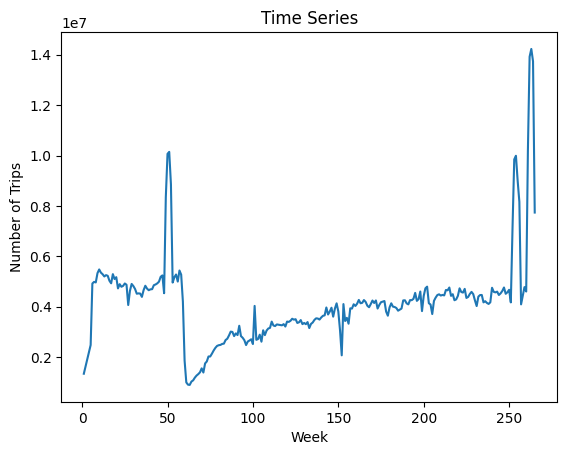

week,count
26,4873456
22,4896862
23,4793698
25,4924628
24,4829736
1,1343678
52,8863638
48,4538421
49,8344364
51,10145932


In [0]:
df_time = df.groupBy("week").count()
abc = df_time.select("week","count").orderBy("week").collect()
(x_values, y_values) = zip(*abc)
plt.plot(x_values, y_values)
plt.title('Time Series')
plt.xlabel('Week')
plt.ylabel('Number of Trips')
plt.show()
display(df_time)

In [0]:
df = df.dropna()

In [0]:
pu_zone = df.groupBy("PUZone").count()
display(pu_zone)

In [0]:
do_zone = df.groupBy("DOZone").count()
display(do_zone)